<a href="https://colab.research.google.com/github/UttaraKet1607/Malarial-Cell-Image-Segmentation/blob/main/Autoencoder_Reconstruction_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download iarunava/cell-images-for-detecting-malaria
! unzip cell-images-for-detecting-malaria.zip

# Autoencoder for uninfected malaria cell images

## Imports

In [3]:
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import subtract, Input, Conv2D, SeparableConv2D, MaxPooling2D, UpSampling2D, SpatialDropout2D, LeakyReLU

In [4]:
tf.__version__

'2.8.0'

### Set logging to Error only

In [5]:
tf.get_logger().setLevel('ERROR')

### Check for GPU

In [6]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Constants

### Data Preparation

In [7]:
RANDOM_STATE = 42
BASE_PATH = "/content/cell_images/Uninfected"
IMAGE_SIZE = (128, 128)
VAL_SIZE = 0.2
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1_000

### Training

In [8]:
EPOCHS = 10
LEARNING_RATE = 0.004

### Callbacks

In [9]:
EARLY_STOP_PATIENCE = 10
REDUCE_LR_FACTOR = 0.2
REDUCE_LR_PATIENCE = 4
REDUCE_LR_COOLDOWN = 3
REDUCE_LR_MIN = 1e-5

### Saving

In [10]:
PLOTS_DPI = 200
MODEL_NAME = 'Autoencoder_Reconstruction'
PLOTS_DIR = os.path.join('plots', MODEL_NAME)
TB_LOGS = "tensorboard_logs/Autoencoder_Reconstruction/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

## Data Loading

In [11]:
image_names = Dataset.list_files(os.path.join(BASE_PATH, '*.png'), seed = RANDOM_STATE)
image_count = image_names.cardinality().numpy()
print(f"\nTotal number of image files: {image_count}")


Total number of image files: 13779


### Image data loading with augmentations

In [12]:
def load_augmented_images(file_path):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, IMAGE_SIZE)

    img_rotneg90 = tf.image.rot90(img, k = -1)
    img_rotpos90 = tf.image.rot90(img, k = 1)

    return img_rotneg90/255.0, img/255.0, img_rotpos90/255.0

image_data = image_names.map(load_augmented_images, num_parallel_calls = AUTOTUNE)
image_data = image_data.flat_map(lambda rotneg90, original, rotpos90: Dataset.from_tensor_slices([rotneg90, original, rotpos90]))


### Augmented data visualization

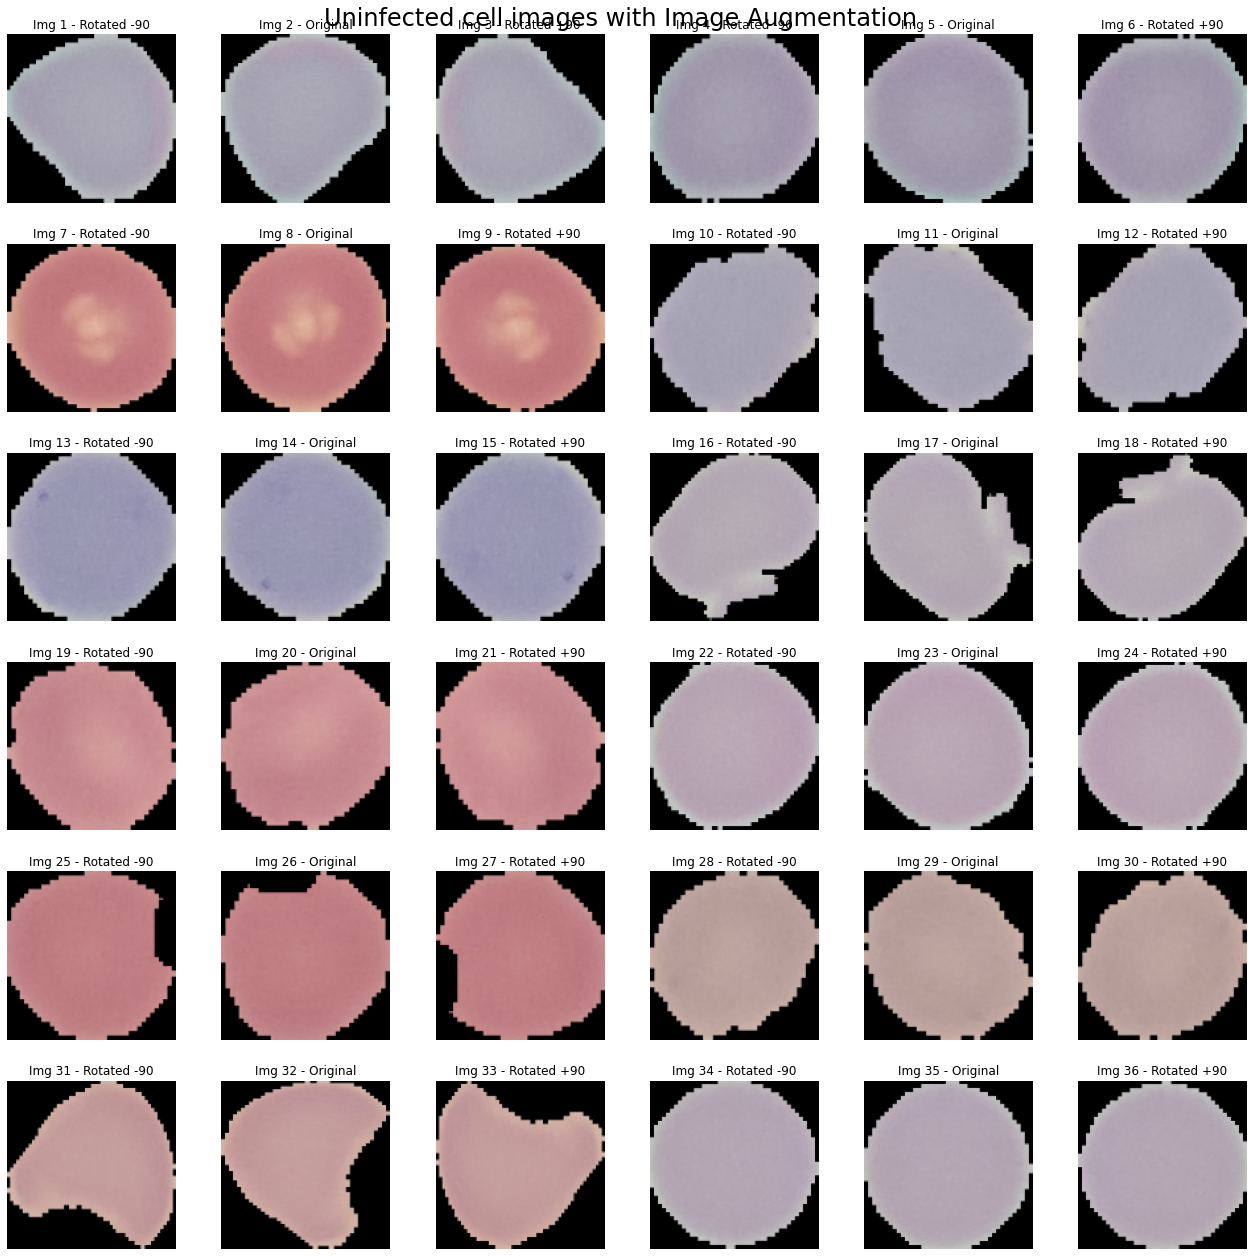

In [13]:
title_suffixes = ['Rotated -90', 'Original', 'Rotated +90']

plt.subplots(nrows = 6, ncols = 6, figsize = (18, 18))
plt.suptitle('Uninfected cell images with Image Augmentation', fontsize = 24)
plt.tight_layout(rect = [0, 0, 1, 0.97], h_pad = 2)

for i, img in enumerate(image_data.take(36)):
    plt.subplot(6, 6, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.title(f"Img {i + 1} - {title_suffixes[i % 3]}")
    plt.imshow(img.numpy())

### Data splitting

In [14]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size = SHUFFLE_BUFFER_SIZE)
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size = AUTOTUNE)
  return ds

def create_autoencoder_dataset(img):
    return img, img

In [15]:
val_image_count = int(image_count * VAL_SIZE * 3)

train_images = image_data.skip(val_image_count)
val_images = image_data.take(val_image_count)

train_ds = configure_for_performance(train_images.map(create_autoencoder_dataset))
val_ds = configure_for_performance(val_images.map(create_autoencoder_dataset))

## Model Creation

### Input Layer

In [16]:
inputLayer = Input(shape = (*IMAGE_SIZE, 3), name = 'Input')

### Encoder

In [17]:
depth_conv = SeparableConv2D(16, (4, 4), activation = LeakyReLU(), padding = 'same', name = "Depth_Conv")(inputLayer)
depth_conv.shape

TensorShape([None, 128, 128, 16])

In [18]:
conv_1 = Conv2D(32, (3, 3), activation = LeakyReLU(), padding = 'same', name = "Enc_Conv_1")(depth_conv)
pool_1 = MaxPooling2D((4, 4), padding = 'same', name = "Enc_MaxPool_1")(conv_1)
pool_1.shape

TensorShape([None, 32, 32, 32])

In [19]:
conv_2 = Conv2D(64, (3, 3), activation = LeakyReLU(), padding = 'same', name = "Enc_Conv_2")(pool_1)
pool_2 = MaxPooling2D((4, 4), padding = 'same', name = "Enc_MaxPool_2")(conv_2)
pool_2.shape

TensorShape([None, 8, 8, 64])

In [20]:
conv_3 = Conv2D(128, (2, 2), activation = LeakyReLU(), padding = 'same', name = "Enc_Conv_3")(pool_2)
pool_3 = MaxPooling2D((2, 2), padding = 'same', name = "Enc_MaxPool_3")(conv_3)
pool_3.shape

TensorShape([None, 4, 4, 128])

In [21]:
conv_4 = Conv2D(256, (2, 2), activation = LeakyReLU(), padding = 'same', name = "Enc_Conv_4")(pool_3)
pool_4 = MaxPooling2D((2, 2), padding = 'same', name = "Enc_MaxPool_4")(conv_4)
pool_4.shape

TensorShape([None, 2, 2, 256])

### Dropout

In [22]:
dropout_1 = SpatialDropout2D(0.1, name = "Dropout_1")(pool_4)
dropout_1.shape

TensorShape([None, 2, 2, 256])

### Decoder

In [23]:
conv_5 = Conv2D(128, (2, 2), activation = LeakyReLU(), padding = 'same', name = "Dec_Conv_1")(dropout_1)
up_1 = UpSampling2D((2, 2), name = "Dec_Upsampling_1")(conv_5)
up_1.shape

TensorShape([None, 4, 4, 128])

In [24]:
conv_6 = Conv2D(64, (2, 2), activation = LeakyReLU(), padding = 'same', name = "Dec_Conv_2")(up_1)
up_2 = UpSampling2D((2, 2), name = "Dec_Upsampling_2")(conv_6)
up_2.shape

TensorShape([None, 8, 8, 64])

In [25]:
conv_7 = Conv2D(32, (3, 3), activation = LeakyReLU(), padding = 'same', name = "Dec_Conv_3")(up_2)
up_3 = UpSampling2D((4, 4), name = "Dec_Upsampling_3")(conv_7)
up_3.shape

TensorShape([None, 32, 32, 32])

In [26]:
conv_8 = Conv2D(16, (3, 3), activation = LeakyReLU(), padding = 'same', name = "Dec_Conv_4")(up_3)
up_4 = UpSampling2D((4, 4), name = "Dec_Upsampling_4")(conv_8)
up_4.shape

TensorShape([None, 128, 128, 16])

### Dropout

In [27]:
dropout_2 = SpatialDropout2D(0.1, name = "Dropout_2")(up_4)
dropout_2.shape

TensorShape([None, 128, 128, 16])

### Output

In [28]:
outputLayer = SeparableConv2D(3, (4, 4), activation = 'sigmoid', padding = 'same', name = 'Reconstruction_Output')(dropout_2)
outputLayer.shape

TensorShape([None, 128, 128, 3])

### Model compilation

In [29]:
autoencoder = Model(inputs = inputLayer, outputs = outputLayer, name = MODEL_NAME)
autoencoder.compile(optimizer = Adam(LEARNING_RATE), loss = 'binary_crossentropy', metrics = ['mse'])

### Model Summary

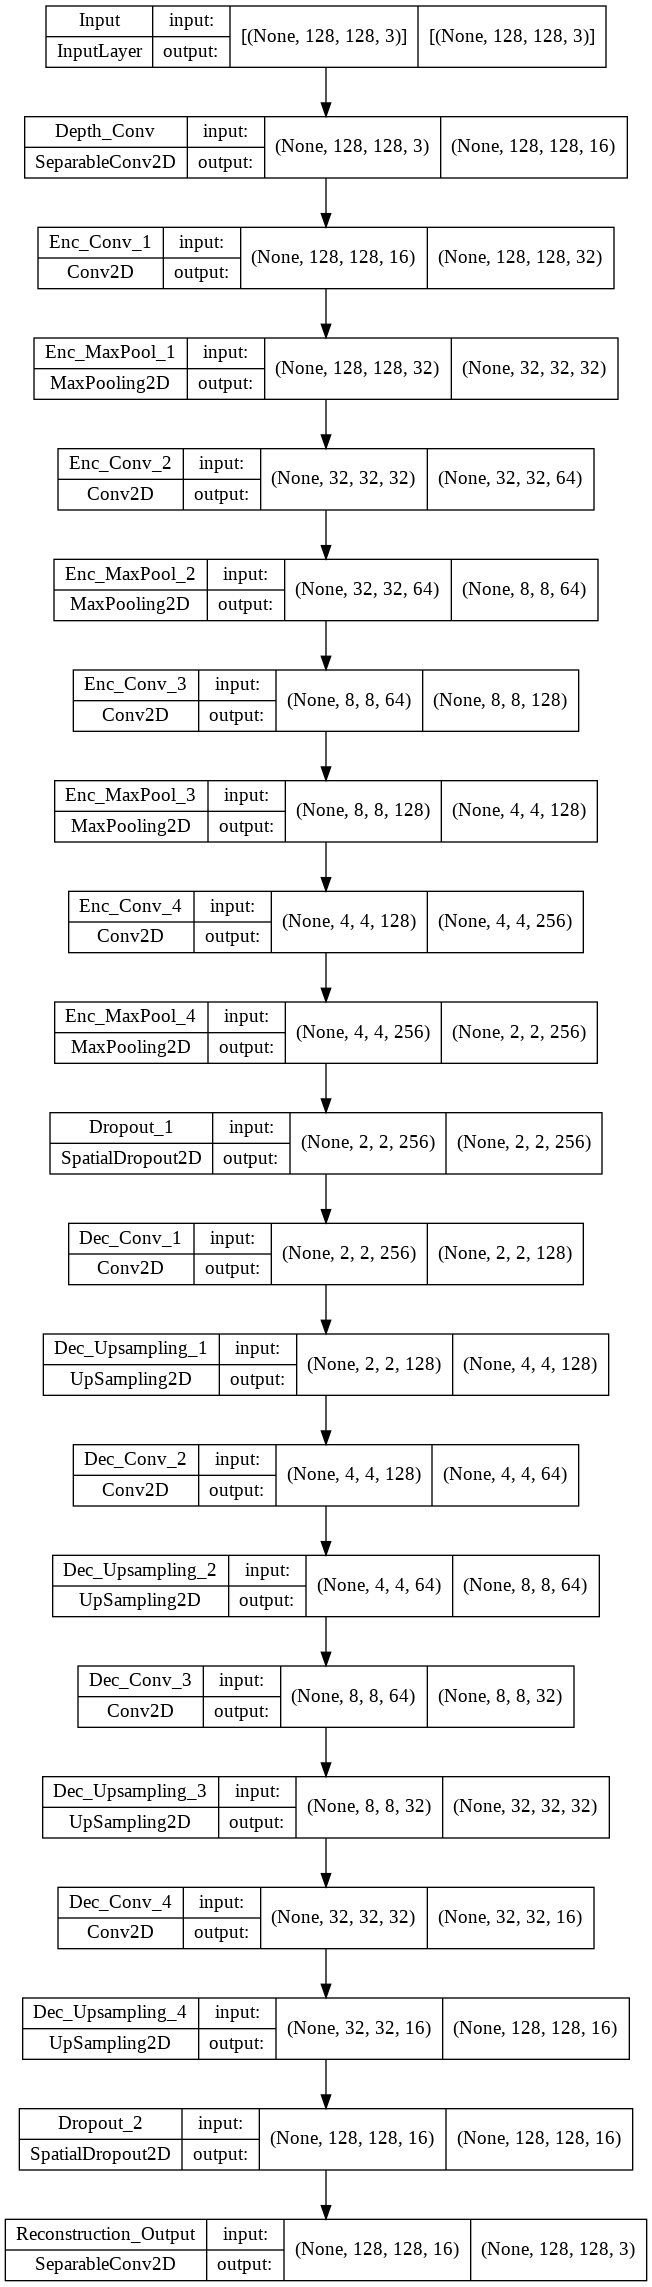

In [30]:
tf.keras.utils.plot_model(autoencoder, show_shapes = True)

In [31]:
autoencoder.summary()

Model: "Autoencoder_Reconstruction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 Depth_Conv (SeparableConv2D  (None, 128, 128, 16)     112       
 )                                                               
                                                                 
 Enc_Conv_1 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 Enc_MaxPool_1 (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 Enc_Conv_2 (Conv2D)         (None, 32, 32, 64)        18496     
                                                                 
 Enc_MaxPool_2 (MaxPooling2D  (None, 8, 

## Model Training

### Callbacks

In [32]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE, restore_best_weights = True)

tensorboard = TensorBoard(log_dir = TB_LOGS)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = REDUCE_LR_FACTOR, 
    patience = REDUCE_LR_PATIENCE, 
    verbose = 1, cooldown = 
    REDUCE_LR_COOLDOWN, 
    min_lr = REDUCE_LR_MIN
)

### Training history

In [33]:
%%time
history = autoencoder.fit(train_ds, epochs = EPOCHS, verbose = 1, validation_data = val_ds, callbacks = [early_stop, tensorboard, reduce_lr])

Epoch 1/10
517/517 [==============================] - 286s 524ms/step - loss: 0.5157 - mse: 0.0211 - val_loss: 0.4914 - val_mse: 0.0124 - lr: 0.0040
Epoch 2/10
517/517 [==============================] - 269s 520ms/step - loss: 0.4888 - mse: 0.0115 - val_loss: 0.4831 - val_mse: 0.0096 - lr: 0.0040
Epoch 3/10
517/517 [==============================] - 271s 523ms/step - loss: 0.4843 - mse: 0.0099 - val_loss: 0.4801 - val_mse: 0.0086 - lr: 0.0040
Epoch 4/10
517/517 [==============================] - 269s 521ms/step - loss: 0.4823 - mse: 0.0092 - val_loss: 0.4791 - val_mse: 0.0082 - lr: 0.0040
Epoch 5/10
517/517 [==============================] - 270s 522ms/step - loss: 0.4809 - mse: 0.0087 - val_loss: 0.4780 - val_mse: 0.0079 - lr: 0.0040
Epoch 6/10
517/517 [==============================] - 269s 520ms/step - loss: 0.4801 - mse: 0.0084 - val_loss: 0.4772 - val_mse: 0.0075 - lr: 0.0040
Epoch 7/10
517/517 [==============================] - 269s 520ms/step - loss: 0.4795 - mse: 0.0083 - val_l

## Model Evaluation

### Model Loss over Epochs

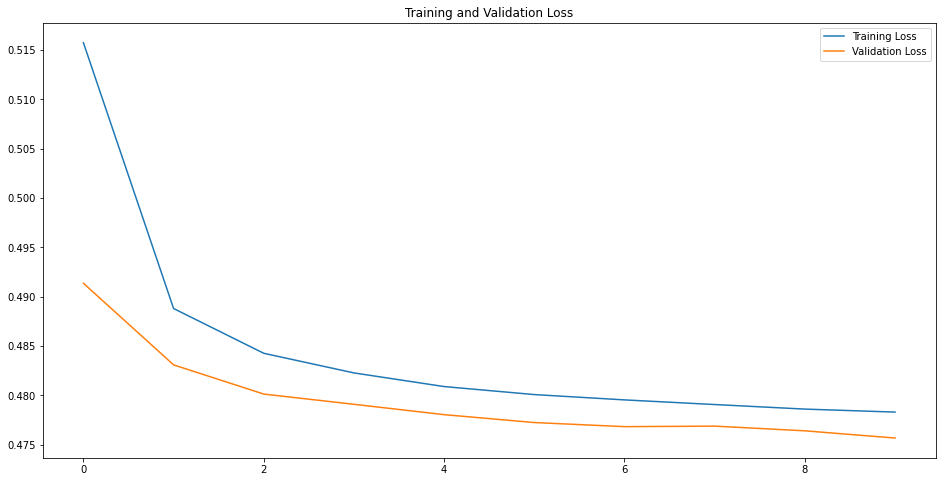

In [34]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize = (16, 8))
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

### Prediction Visualization

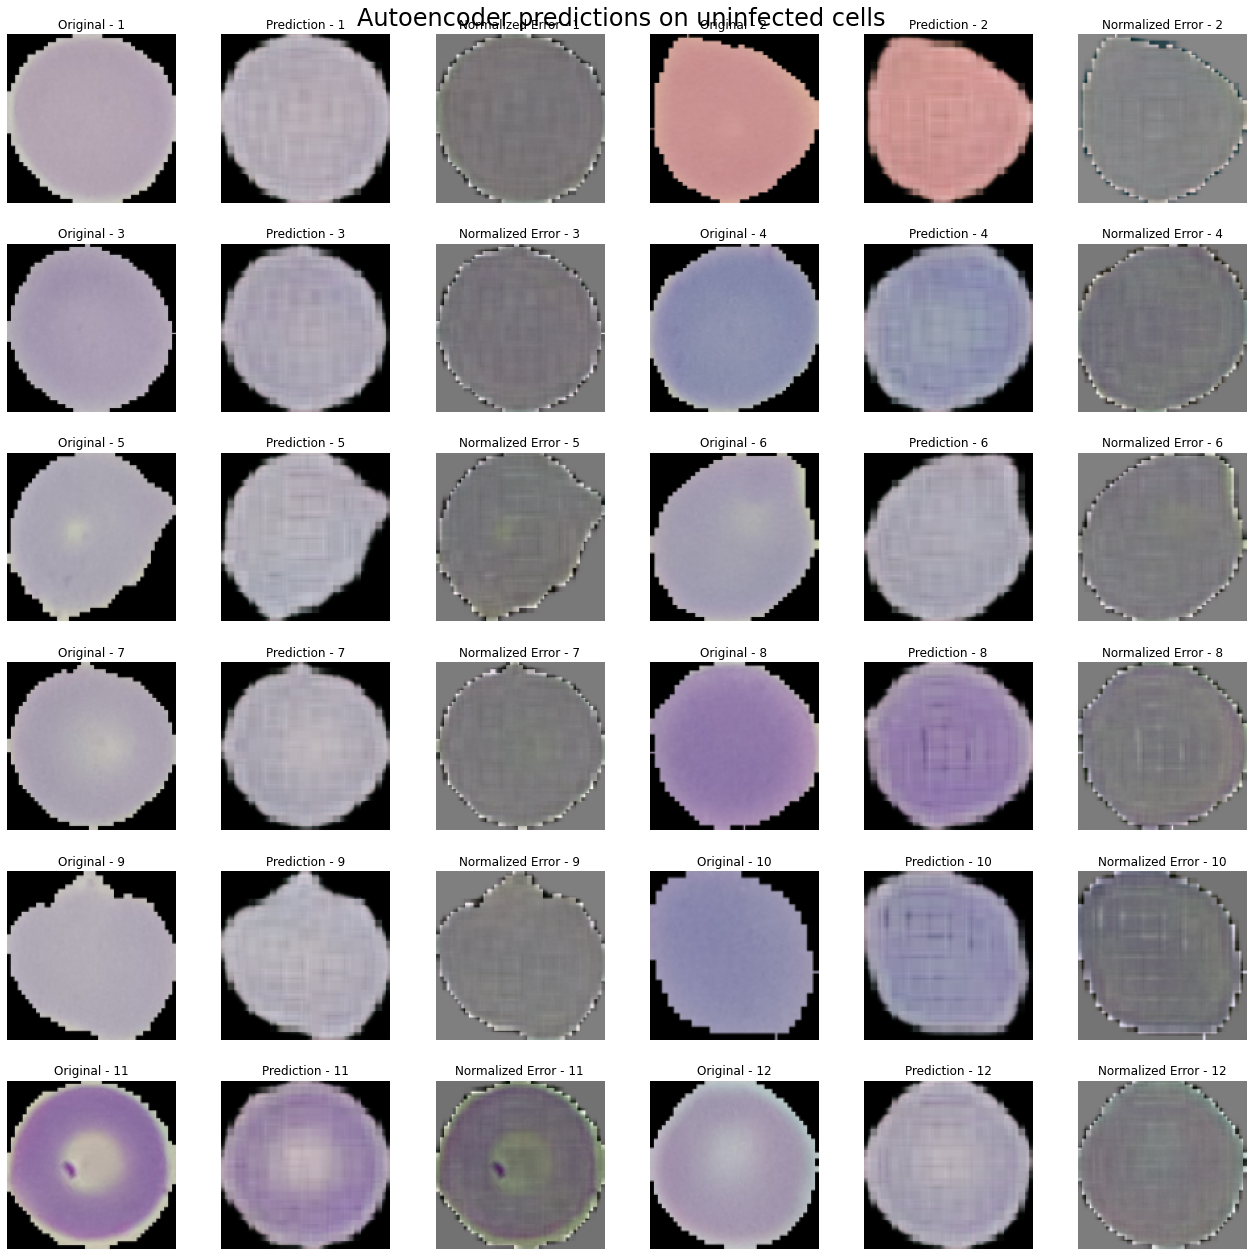

In [35]:
plt.subplots(nrows = 6, ncols = 6, figsize = (18, 18))

plt.suptitle('Autoencoder predictions on uninfected cells', fontsize = 24)
plt.tight_layout(rect = [0, 0, 1, 0.97], h_pad = 2)

for i in val_ds.take(1):
    val_data = i[0][:12].numpy()

val_data = np.array(val_data)
pred = autoencoder.predict(val_data)
pred_error = val_data - pred
pred_error_min = pred_error.min(axis = (1, 2, 3)).reshape(12, 1, 1, 1)
pred_error_max = pred_error.max(axis = (1, 2, 3)).reshape(12, 1, 1, 1)
norm_error = (pred_error - pred_error_min)/(pred_error_max - pred_error_min)

for i in range(len(val_data)):
    plt.subplot(6, 6, (3 * i) + 1)
    plt.axis(False)
    plt.grid(False)
    plt.title(f"Original - {i + 1}")
    plt.imshow(val_data[i])

    plt.subplot(6, 6, (3 * i) + 2)
    plt.axis(False)
    plt.grid(False)
    plt.title(f"Prediction - {i + 1}")
    plt.imshow(pred[i])

    plt.subplot(6, 6, (3 * i) + 3)
    plt.axis(False)
    plt.grid(False)
    plt.title(f"Normalized Error - {i + 1}")
    plt.imshow(norm_error[i])

plt.show()

## Model Saving

In [36]:
autoencoder.save(os.path.join('models', MODEL_NAME))

## Autoencoder Classification

In [37]:
import os
import cv2
import json
import glob
import datetime
from tqdm import tqdm
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [38]:
labelEncoding = {
    'Uninfected' : 0,
    'Parasitized' : 1
}
labelEncoding

{'Parasitized': 1, 'Uninfected': 0}

In [39]:
labelDecoding = {v: k for k, v in labelEncoding.items()}
labelDecoding

{0: 'Uninfected', 1: 'Parasitized'}

In [40]:
parasitized_data = os.listdir('/content/cell_images/Parasitized')
uninfected_data = os.listdir('/content/cell_images/Uninfected/')

In [41]:
%%time

imageData = []
imageLabels = []

for img in parasitized_data:
    try:
        img_read = plt.imread('/content/cell_images/Parasitized' + "/" + img)
        img_resize = cv2.resize(img_read, (50, 50))
        img = img_to_array(img_resize)
        imageData.append(img)
        imageLabels.append(labelEncoding['Parasitized'])
    except:
        None
        
for img in uninfected_data:
    try:
        img_read = plt.imread('/content/cell_images/Uninfected' + "/" + img)
        img_resize = cv2.resize(img_read, (50, 50))
        img = img_to_array(img_resize)
        imageData.append(img)
        imageLabels.append(labelEncoding['Uninfected'])
    except:
        None

imageData = np.array(imageData).astype('float32')
imageLabels = np.array(imageLabels)

print(f'\nData type of image data: {imageData.dtype}')
print(f'\nShape of image data: {imageData.shape}')
print(f'\nData type of image labels: {imageLabels.dtype}')
print(f'\nShape of image labels: {imageLabels.shape}')


Data type of image data: float32

Shape of image data: (27558, 50, 50, 3)

Data type of image labels: int64

Shape of image labels: (27558,)
CPU times: user 41.8 s, sys: 5.8 s, total: 47.6 s
Wall time: 57.3 s


In [42]:
X_train, X_val, Y_train, Y_val = train_test_split(
    imageData, 
    imageLabels,
    test_size = VAL_SIZE, 
    random_state = RANDOM_STATE,
    stratify = imageLabels
    )

print(f'Training Images: {X_train.shape}')
print(f'\nTraining Labels: {Y_train.shape}')
print(f'\nValidation Data: {X_val.shape}')
print(f'\nValidation Labels: {Y_val.shape}')

Training Images: (22046, 50, 50, 3)

Training Labels: (22046,)

Validation Data: (5512, 50, 50, 3)

Validation Labels: (5512,)


In [43]:
train_gen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True
    )

train_data = train_gen.flow(x = X_train, y = Y_train, batch_size = BATCH_SIZE, shuffle = True)

len(train_data)

345

TypeError: ignored

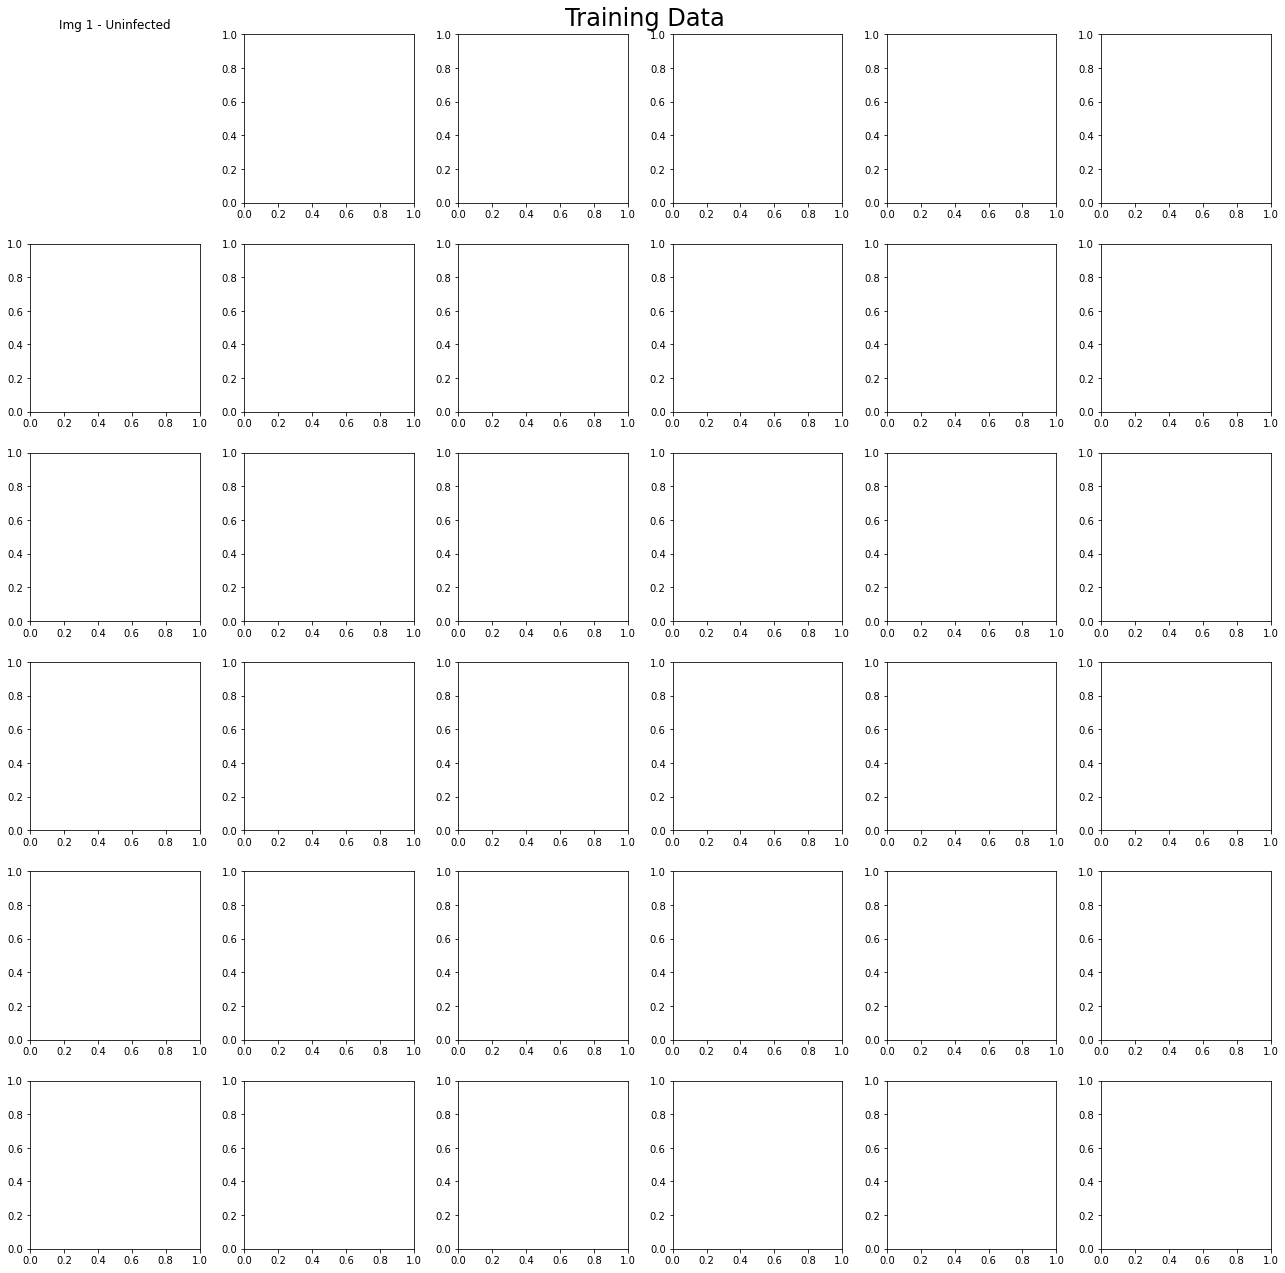

In [46]:
plt.subplots(nrows = 6, ncols = 6, figsize = (18, 18))

plt.suptitle('Training Data', fontsize = 24)
plt.tight_layout(rect = [0, 0, 1, 0.97], h_pad = 2)

#gen_data = train_data.next()

for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.title(f"Img {i + 1} - {labelDecoding[gen_data[1][i]]}")
    plt.imshow(train_data[0][i])

plt.show()

In [ ]:
val_gen = ImageDataGenerator(rescale = 1./255)

val_data = val_gen.flow(x = X_val, y = Y_val, batch_size = BATCH_SIZE, shuffle = True)

len(val_data)

In [ ]:
plt.subplots(nrows = 6, ncols = 6, figsize = (18, 18))

plt.suptitle('Validation Data', fontsize = 24)
plt.tight_layout(rect = [0, 0, 1, 0.97], h_pad = 2)

gen_data = val_data.next()

for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.title(f"Img {i + 1} - {labelDecoding[gen_data[1][i]]}")
    plt.imshow(gen_data[0][i])

plt.show()

In [45]:
autoencoder = tf.keras.models.load_model('/content/models/Autoencoder_Reconstruction')

for layer in autoencoder.layers:
    layer.trainable = False

autoencoder.summary()

Model: "Autoencoder_Reconstruction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 Depth_Conv (SeparableConv2D  (None, 128, 128, 16)     112       
 )                                                               
                                                                 
 Enc_Conv_1 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 Enc_MaxPool_1 (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 Enc_Conv_2 (Conv2D)         (None, 32, 32, 64)        18496     
                                                                 
 Enc_MaxPool_2 (MaxPooling2D  (None, 8, 

In [ ]:
plt.subplots(nrows = 6, ncols = 6, figsize = (18, 18))

plt.suptitle('Autoencoder predictions', fontsize = 24)
plt.tight_layout(rect = [0, 0, 1, 0.97], h_pad = 2)

gen_data = train_data.next()
pred = autoencoder.predict(gen_data[0][:12])
pred_error = gen_data[0][:12] - pred
pred_error_min = pred_error.min(axis = (1, 2, 3)).reshape(12, 1, 1, 1)
pred_error_max = pred_error.max(axis = (1, 2, 3)).reshape(12, 1, 1, 1)
norm_error = (pred_error - pred_error_min)/(pred_error_max - pred_error_min)

for i in range(len(pred)):
    plt.subplot(6, 6, (3 * i) + 1)
    plt.axis(False)
    plt.grid(False)
    plt.title(f"Img {i + 1} - {labelDecoding[gen_data[1][i]]}")
    plt.imshow(gen_data[0][i])

    plt.subplot(6, 6, (3 * i) + 2)
    plt.axis(False)
    plt.grid(False)
    plt.title(f"Prediction - {i + 1}")
    plt.imshow(pred[i])

    plt.subplot(6, 6, (3 * i) + 3)
    plt.axis(False)
    plt.grid(False)
    plt.title(f"Normalized Error - {i + 1}")
    plt.imshow(norm_error[i])

plt.savefig(os.path.join(PLOTS_DIR, 'autoencoder_predictions.jpg'), dpi = PLOTS_DPI, bbox_inches = 'tight')
plt.show()

In [ ]:
reconstructionErrorLayer = subtract([autoencoder.input, autoencoder.output], name = "Reconstruction_Error")
reconstructionErrorLayer.shape

In [ ]:
classifier = Model(inputs = autoencoder.input, outputs = reconstructionErrorLayer, name = MODEL_NAME)

classifier.compile(
    optimizer = Adam(LEARNING_RATE), 
    loss = 'sparse_categorical_crossentropy', 
    metrics = ['sparse_categorical_accuracy']
    )

classifier.summary()